In [ ]:
#

In [1]:
import pandas as pd
import numpy as np
from easymore.easymore import easymore
import matplotlib.pyplot as plt


In [2]:
#
min_lat = 48.0
max_lat = 52.0
max_lon = -110.0
min_lon = -117.0
n_number = 1000

# 
point_df_target = pd.DataFrame()
point_df_target ['lat_t'] = np.random.uniform(low=min_lat, high=max_lat, size=(n_number,))
point_df_target ['lon_t'] = np.random.uniform(low=min_lon, high=max_lon, size=(n_number,))
point_df_target ['ID_t'] = np.arange(n_number)+1

#
esmr = easymore()
point_target = esmr.make_shape_point(point_df_target, lon_column = 'lon_t' , lat_column = 'lat_t', crs = 'epsg:4326')


EASYMORE version 1.0.0 is initiated.
crs  epsg:4326  is assigned to the point shapefile


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
#

esmr = easymore()

# specifying EASYMORE objects
# temporary path that the EASYMORE generated GIS files and remapped file will be saved
esmr.temp_dir                 = './temporary/'
esmr.source_nc                = './data/Source_nc_WRF/WRF*.nc'
# name of variables from source netCDF file(s) to be remapped
esmr.var_names                = ['T2']
# name of variable longitude in source netCDF files
esmr.var_lon                  = 'XLONG'
# name of variable latitude in source netCDF files
esmr.var_lat                  = 'XLAT'
# name of variable time in source netCDF file; should be always time
esmr.var_time                 = 'time'
# location where the remapped netCDF file will be saved
esmr.output_dir               = './output/'

esmr.NetCDF_SHP_lat_lon()

wrf_lat = esmr.lat
wrf_lon = esmr.lon
case_type = esmr.case

point_df_source = pd.DataFrame()
point_df_source ['lat_s'] = wrf_lat.flatten()
point_df_source ['lon_s'] = wrf_lon.flatten()
point_df_source ['ID_s'] = np.arange(len(point_df_source))+1

point_source = esmr.make_shape_point(point_df_source, lon_column = 'lon_s' , lat_column = 'lat_s', crs = 'epsg:4326')


EASYMORE version 1.0.0 is initiated.
EASYMORE detects case 2 - rotated lat/lon
crs  epsg:4326  is assigned to the point shapefile


In [4]:
# loop over the random point and find the weigth to for each point based on inverse distance to wrf grid location

point_target = point_target.to_crs("EPSG:6933")
point_target ['lat_t_m'] = point_target.centroid.y
point_target ['lon_t_m'] = point_target.centroid.x

point_source = point_source.to_crs("EPSG:6933")
point_source ['lat_s_m'] = point_source.centroid.y
point_source ['lon_s_m'] = point_source.centroid.x

powers = [0.5,1,2,3,4]

for power in powers:
    remapping_df = pd.DataFrame()
    for index, row in point_target.iterrows():
        # get the distance
        point_source['distance'] = ((row.lat_t_m-point_source['lat_s_m'])**2+\
                                   (row.lon_t_m-point_source['lon_s_m'])**2)**0.5
        point_source['distance'] = point_source['distance']/1000 # meters to kilometers
        point_source['weight'] = (1/point_source['distance'])**power
        point_source['weight'] = point_source['weight']/(point_source['weight'].sum())
        point_source = point_source.sort_values(by='weight',ascending=False)
        temp = point_source.head(30)
        temp['weight'] = temp['weight']/(temp['weight'].sum())
        temp['ID_t'] = row.ID_t
        temp['lon_t'] = row.lon_t
        temp['lat_t'] = row.lat_t
        temp['easymore_case'] = case_type # in this case 2; rotated lat/lon
        temp['order_t'] = index # or can be ID_t
        if not temp.empty:
            remapping_df = remapping_df.append(temp)
        # if there is a large weight just keep that
    remapping_df.reset_index(inplace=True)
    print(remapping_df)
    
    remapping_df['rows'], remapping_df['cols'] = \
    esmr.create_row_col_df (wrf_lat,wrf_lon,remapping_df.lat_s,remapping_df.lon_s)
    
    # specifying EASYMORE objects
    # temporary path that the EASYMORE generated GIS files and remapped file will be saved
    esmr = easymore()
    esmr.case_name                = 'WRF_Medicine_Hat_Resample_'+str(power)
    esmr.temp_dir                 = './temporary/'
    esmr.source_nc                = './data/Source_nc_WRF/WRF*.nc'
    esmr.var_names                = ['T2']
    esmr.var_lon                  = 'XLONG'
    esmr.var_lat                  = 'XLAT'
    esmr.var_time                 = 'time'
    esmr.output_dir               = './output/'
    esmr.remap_csv                = esmr.temp_dir+esmr.case_name+'_remapping.csv'
    
    remapping_df.to_csv(esmr.temp_dir+esmr.case_name+'_remapping.csv')

    # execute EASYMORE
    esmr.nc_remapper()
    

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


       index      lat_s       lon_s   ID_s                           geometry  \
0       9449  49.231968 -113.993439   9450  POINT (-10998802.875 5550072.343)   
1       9648  49.267483 -114.003174   9649  POINT (-10999742.179 5553052.703)   
2       9250  49.196461 -113.983734   9251  POINT (-10997866.515 5547090.505)   
3       9448  49.225620 -114.047821   9449  POINT (-11004050.023 5549539.432)   
4       9249  49.190105 -114.038086   9250  POINT (-11003110.719 5546556.575)   
...      ...        ...         ...    ...                                ...   
29995  11398  49.307430 -116.323547  11399  POINT (-11223626.391 5556402.515)   
29996  11797  49.385326 -116.291565  11798  POINT (-11220540.526 5562926.798)   
29997  11997  49.427872 -116.248383  11998  POINT (-11216374.019 5566485.919)   
29998  11004  49.265575 -116.084717  11005  POINT (-11200582.518 5552892.695)   
29999  11998  49.435089 -116.194077  11999  POINT (-11211134.232 5567089.388)   

            lat_s_m       l

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


       index      lat_s       lon_s   ID_s                           geometry  \
0       9449  49.231968 -113.993439   9450  POINT (-10998802.875 5550072.343)   
1       9648  49.267483 -114.003174   9649  POINT (-10999742.179 5553052.703)   
2       9250  49.196461 -113.983734   9251  POINT (-10997866.515 5547090.505)   
3       9448  49.225620 -114.047821   9449  POINT (-11004050.023 5549539.432)   
4       9249  49.190105 -114.038086   9250  POINT (-11003110.719 5546556.575)   
...      ...        ...         ...    ...                                ...   
29995  11398  49.307430 -116.323547  11399  POINT (-11223626.391 5556402.515)   
29996  11797  49.385326 -116.291565  11798  POINT (-11220540.526 5562926.798)   
29997  11997  49.427872 -116.248383  11998  POINT (-11216374.019 5566485.919)   
29998  11004  49.265575 -116.084717  11005  POINT (-11200582.518 5552892.695)   
29999  11998  49.435089 -116.194077  11999  POINT (-11211134.232 5567089.388)   

            lat_s_m       l

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


       index      lat_s       lon_s   ID_s                           geometry  \
0       9449  49.231968 -113.993439   9450  POINT (-10998802.875 5550072.343)   
1       9648  49.267483 -114.003174   9649  POINT (-10999742.179 5553052.703)   
2       9250  49.196461 -113.983734   9251  POINT (-10997866.515 5547090.505)   
3       9448  49.225620 -114.047821   9449  POINT (-11004050.023 5549539.432)   
4       9249  49.190105 -114.038086   9250  POINT (-11003110.719 5546556.575)   
...      ...        ...         ...    ...                                ...   
29995  11398  49.307430 -116.323547  11399  POINT (-11223626.391 5556402.515)   
29996  11797  49.385326 -116.291565  11798  POINT (-11220540.526 5562926.798)   
29997  11997  49.427872 -116.248383  11998  POINT (-11216374.019 5566485.919)   
29998  11004  49.265575 -116.084717  11005  POINT (-11200582.518 5552892.695)   
29999  11998  49.435089 -116.194077  11999  POINT (-11211134.232 5567089.388)   

            lat_s_m       l

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


       index      lat_s       lon_s   ID_s                           geometry  \
0       9449  49.231968 -113.993439   9450  POINT (-10998802.875 5550072.343)   
1       9648  49.267483 -114.003174   9649  POINT (-10999742.179 5553052.703)   
2       9250  49.196461 -113.983734   9251  POINT (-10997866.515 5547090.505)   
3       9448  49.225620 -114.047821   9449  POINT (-11004050.023 5549539.432)   
4       9249  49.190105 -114.038086   9250  POINT (-11003110.719 5546556.575)   
...      ...        ...         ...    ...                                ...   
29995  11398  49.307430 -116.323547  11399  POINT (-11223626.391 5556402.515)   
29996  11797  49.385326 -116.291565  11798  POINT (-11220540.526 5562926.798)   
29997  11997  49.427872 -116.248383  11998  POINT (-11216374.019 5566485.919)   
29998  11004  49.265575 -116.084717  11005  POINT (-11200582.518 5552892.695)   
29999  11998  49.435089 -116.194077  11999  POINT (-11211134.232 5567089.388)   

            lat_s_m       l

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


       index      lat_s       lon_s   ID_s                           geometry  \
0       9449  49.231968 -113.993439   9450  POINT (-10998802.875 5550072.343)   
1       9648  49.267483 -114.003174   9649  POINT (-10999742.179 5553052.703)   
2       9250  49.196461 -113.983734   9251  POINT (-10997866.515 5547090.505)   
3       9448  49.225620 -114.047821   9449  POINT (-11004050.023 5549539.432)   
4       9249  49.190105 -114.038086   9250  POINT (-11003110.719 5546556.575)   
...      ...        ...         ...    ...                                ...   
29995  11398  49.307430 -116.323547  11399  POINT (-11223626.391 5556402.515)   
29996  11797  49.385326 -116.291565  11798  POINT (-11220540.526 5562926.798)   
29997  11997  49.427872 -116.248383  11998  POINT (-11216374.019 5566485.919)   
29998  11004  49.265575 -116.084717  11005  POINT (-11200582.518 5552892.695)   
29999  11998  49.435089 -116.194077  11999  POINT (-11211134.232 5567089.388)   

            lat_s_m       l

In [5]:
import xarray as xr

ds_05 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_0.5_remapped_2000-10-01-00-00-00.nc')
ds_1 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_1_remapped_2000-10-01-00-00-00.nc')
ds_2 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_2_remapped_2000-10-01-00-00-00.nc')
ds_3 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_3_remapped_2000-10-01-00-00-00.nc')
ds_4 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_4_remapped_2000-10-01-00-00-00.nc')


<AxesSubplot:>

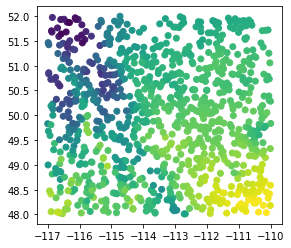

In [6]:
point_target ['values'] = ds_05['T2'][23,:].values
point_target_plot  = point_target.to_crs('epsg:4326')
point_target_plot.plot(column='values')

<AxesSubplot:title={'center':'time = 2000-10-01T23:00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

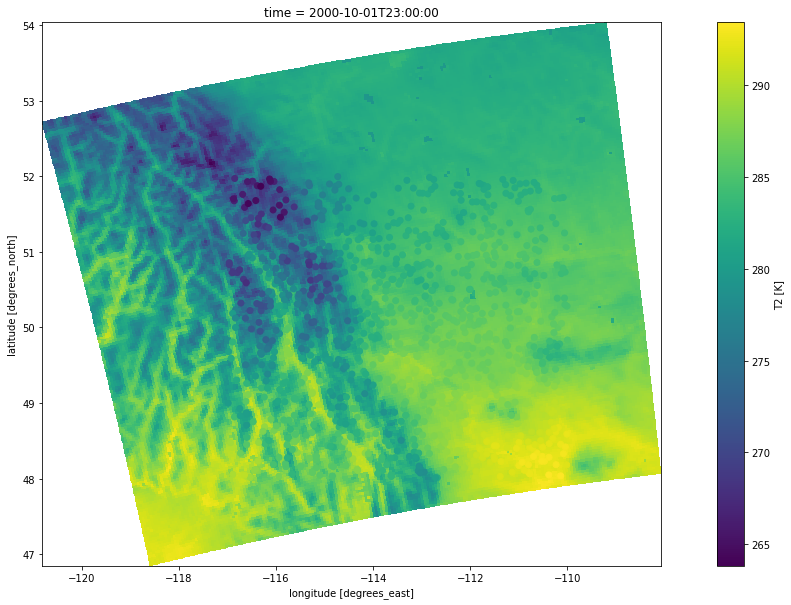

In [7]:
ds_source = xr.open_dataset('./data/Source_nc_WRF/WRF_merged_2000-10-01.nc')


fig, ax = fig, ax = plt.subplots(figsize=(20,10))
fig.set_facecolor("white")

ds_source['T2'].sel(time='2000-10-01 23:00:00', method='nearest').plot.pcolormesh(x='XLONG',
                                                                                  y='XLAT',
                                                                                  add_colorbar=True,
                                                                                  ax=ax,
                                                                                  cmap='viridis')

point_target_plot.plot(column='values',ax=ax)

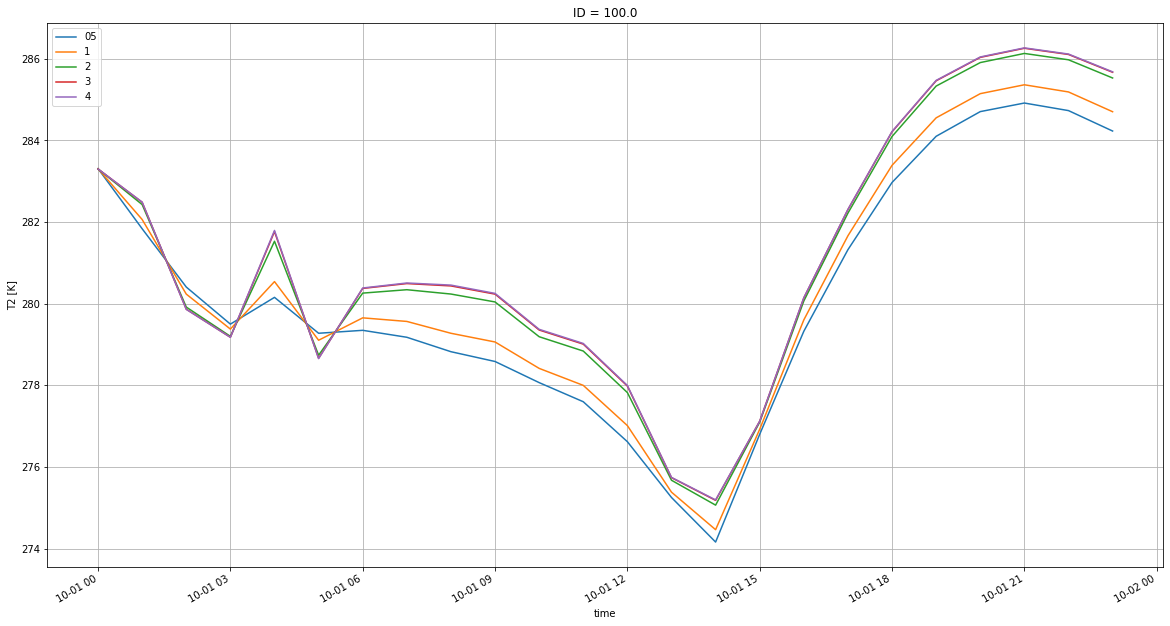

In [8]:
fig, ax = fig, ax = plt.subplots(figsize=(20,10))
fig.set_facecolor("white")

ds_05['T2'][:,99].plot(ax=ax, label = '05')
ds_1['T2'][:,99].plot(ax=ax, label = '1')
ds_2['T2'][:,99].plot(ax=ax, label = '2')
ds_3['T2'][:,99].plot(ax=ax, label = '3')
ds_4['T2'][:,99].plot(ax=ax, label = '4')

plt.legend()
plt.grid()